In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf

# Part 1: Simple MNIST

#### 1. MNIST Tutorial

In [43]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
x = tf.placeholder(tf.float32, [None, 784])

In [9]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

In [10]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [11]:
y_ = tf.placeholder(tf.float32, [None, 10])

In [12]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [13]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [15]:
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [17]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9202


#### 2. Data

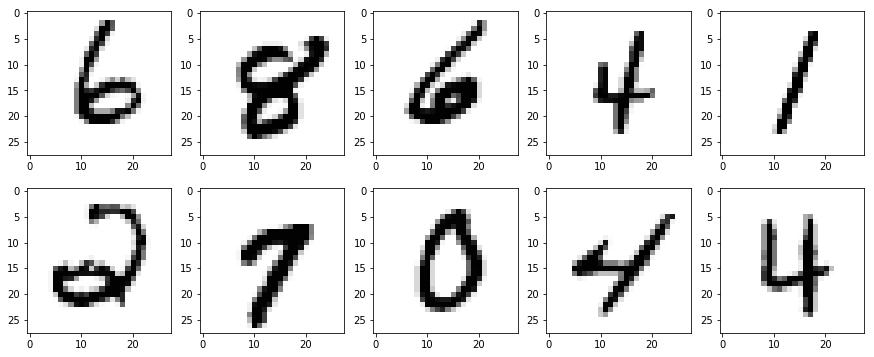

In [48]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(mnist.train.images[i].reshape(28, 28), cmap='Greys', interpolation='none')

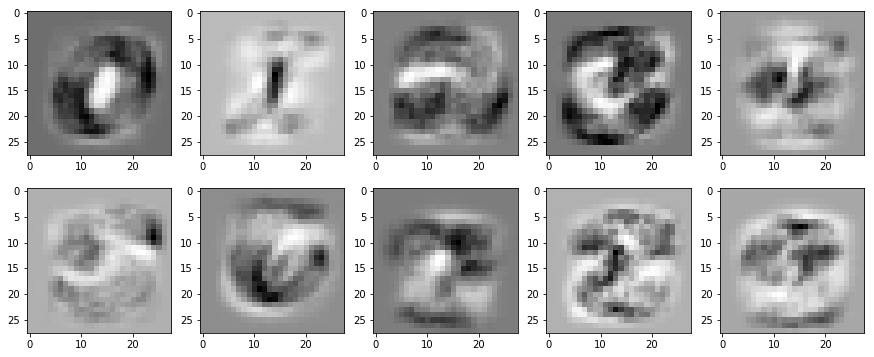

In [47]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(W.eval().T[i].reshape(28, 28), cmap='Greys', interpolation='none')

The weight matrix $W$ has 784 x 10 parameters and the bias $b$ has 10 parameters, therefore the model has 7850 parameters total.

#### 3. Cross-entropy

The cross-entropy is large if the predicted probabilites of the network are not in alignment with the actual class of the image. Its maximal value is infinity. The cross-entropy is small if the prediction of the network matches the actual class of the image. Its minimal value is 0 (then the predicted probability for the class of the image is 1).

# Part 2: Translated MNIST

In [4]:
def translate_mnist(mnist, n_trans=40):
    """
    Takes a DataSets object loaded using
    tensorflow.examples.tutorials.mnist.input_data.read_data_sets
    and replaces the 28x28 images with images of size 40x40.

    :param mnist: DataSets
                    MNIST data loaded using TensorFlow
    :return: None
    """
    for name in ('train', 'validation', 'test'):
        images = getattr(mnist, name).images.reshape((-1, 28, 28))
        n_ims = images.shape[0]
        images_ = np.zeros((n_ims, n_trans, n_trans), dtype=images.dtype)
        trans = np.random.choice(n_trans-28, size=(n_ims, 2))
        for i in range(n_ims):
            x, y = trans[i, :]
            images_[i, x: x+28, y: y+28] = images[i, ...]
        getattr(mnist, name)._images = \
            images_.reshape((n_ims,np.product(images_.shape[1:])))


In [5]:
from tensorflow.examples.tutorials.mnist import input_data
translated_mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
translate_mnist(translated_mnist)

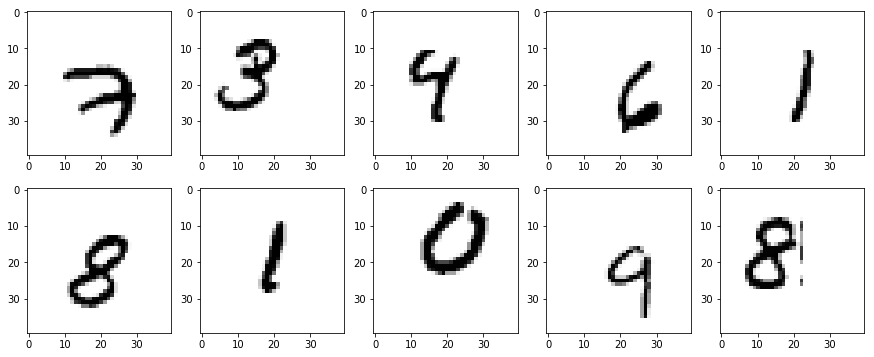

In [7]:
# Plot some of the translated images.
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(translated_mnist.train.images[i].reshape(40, 40), cmap='Greys', interpolation='none')

#### 1. Linear model

In [63]:
x = tf.placeholder(tf.float32, [None, 1600])

W = tf.Variable(tf.zeros([1600, 10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(1000):
    batch_xs, batch_ys = translated_mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: translated_mnist.test.images, y_: translated_mnist.test.labels}))

0.3766


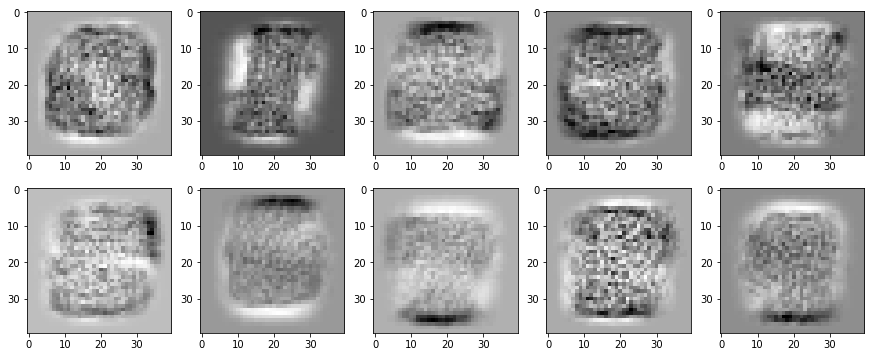

In [64]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(W.eval().T[i].reshape(40, 40), cmap='Greys', interpolation='none')

The weight vectors do not as clearly resemble digits as in part 1. This is because the digits are spread across the images and not centered at the same location. Therefore, the weight vectors cannot spezialize on individual digits (this is also why the accuracy is way lower).

#### 2. Hidden layer

In [13]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [65]:
x = tf.placeholder(tf.float32, [None, 1600])

In [72]:
W1 = weight_variable([1600, 500])
b1 = bias_variable([500])
y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

W2 = weight_variable([500, 10])
b2 = bias_variable([10])
y = tf.nn.softmax(tf.matmul(y1, W2) + b2)

In [73]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [74]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(10000):
    batch_xs, batch_ys = translated_mnist.train.next_batch(50)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [75]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: translated_mnist.test.images, y_: translated_mnist.test.labels}))

0.913


$W1$ has 1600 x 500 parameters, $b1$ has 500 parameters, $W2$ has 500 x 10 parameters, and $b2$ has 10 parameters. All in all, this makes 805510 parameters.

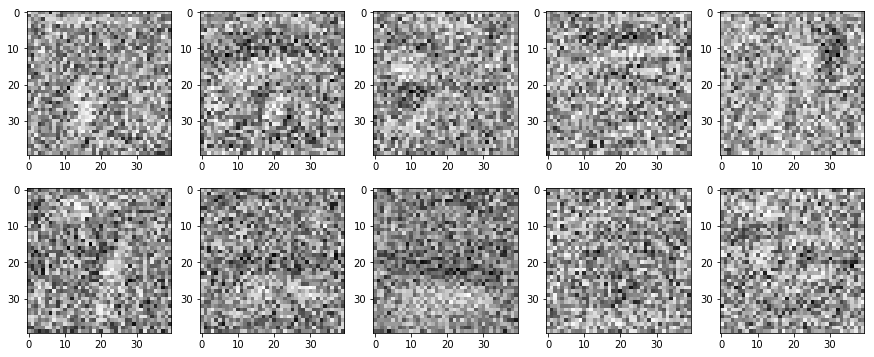

In [76]:
# Note: These are only the first 10 weight vectors, the layer 500 all in all.
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(W1.eval().T[i].reshape(40, 40), cmap='Greys', interpolation='none')

#### 3. ConvNet

In [66]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [67]:
x = tf.placeholder(tf.float32, shape=[None, 1600])
x_image = tf.reshape(x, [-1,40,40,1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [68]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [69]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [70]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [71]:
W_fc1 = weight_variable([10 * 10 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 10*10*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [72]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [73]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [74]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [75]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [76]:
for i in range(20000):
    batch = translated_mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.16
step 100, training accuracy 0.34
step 200, training accuracy 0.58
step 300, training accuracy 0.76
step 400, training accuracy 0.8
step 500, training accuracy 0.7
step 600, training accuracy 0.82
step 700, training accuracy 0.92
step 800, training accuracy 0.9
step 900, training accuracy 0.84
step 1000, training accuracy 0.94
step 1100, training accuracy 0.92
step 1200, training accuracy 0.86
step 1300, training accuracy 0.94
step 1400, training accuracy 0.88
step 1500, training accuracy 0.94
step 1600, training accuracy 0.96
step 1700, training accuracy 0.94
step 1800, training accuracy 0.92
step 1900, training accuracy 0.94
step 2000, training accuracy 0.92
step 2100, training accuracy 1
step 2200, training accuracy 1
step 2300, training accuracy 0.96
step 2400, training accuracy 0.98
step 2500, training accuracy 0.92
step 2600, training accuracy 0.88
step 2700, training accuracy 0.88
step 2800, training accuracy 1
step 2900, training accuracy 0.96
step

In [77]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: translated_mnist.test.images, y_: translated_mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.985


#### 4. Filters

In [81]:
W_conv1.eval().T[0, 0].shape

(5, 5)

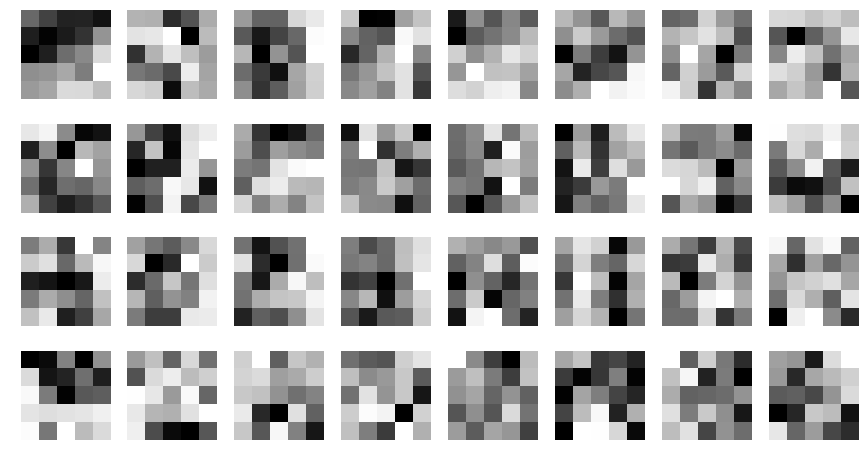

In [86]:
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.imshow(W_conv1.eval().T[i, 0], cmap='Greys', interpolation='none')
    plt.axis('off')

Even though the filters are not super-descriptive of the image content in this case, one can make out simple features like edges and b/w contrasts in some cases.

#### 5. ConvNet vs. fully-connected network

The ConvNet should give a better performance. Firstly, the convolution and pooling layers are more suited for image analysis because they offer translation invariance (i.e. the same feature can be recognized across different locations in the image). Secondly, the ConvNet is deeper than the fully-connected network above, which allows it to learn more complex features. Thirdly, the ConvNet incorporates dropout, which reduces overfitting and can also help the network reach a better accuracy overall.